* This notebook is first in the series of notebooks where we implement the ideas proposed in the [InstructEdit paper](https://arxiv.org/abs/2305.18047).

* In this notebook we will use two different multimodal models to do the following-
  * generate a caption for the input image.
  * identify what type of image it is. Photograph, painting etc.
  
**note** - In original paper only one modal BLIP2 was used for the baove two tasks but I ma using two different models as I have lesser RAM and using BLIP2 eats up too much RAM.

let's import required libraries.

In [1]:
import torch
from pathlib import Path
from fastdownload import download_url
from fastai.vision.all import *

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM

## Caption generator
* We will use a multimodal model "microsoft/git-base-coco" to generate the caption for our image.
* This is a multimodal model which can generate caption for a given image.
* More details for this model can be found [here](https://huggingface.co/microsoft/git-base-coco).

We will use the Autoclasses to initialize the model.


In [3]:
processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

I am using a free image from pexels.com .

### Get the image
* Here i am using the `download_url` function provided by fastai's "fastdownload" library.
* It accepts an image url and downloads it to a given destination.

In [4]:
img_url = 'https://images.pexels.com/photos/13397838/pexels-photo-13397838.jpeg'

In [5]:
path = download_url(img_url, dest=".")

`show_image` is a function provided by fastai library. It helps in displaying a given image.

<Axes: >

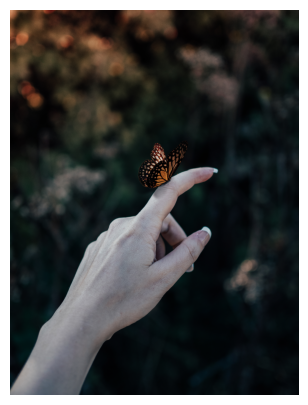

In [6]:
img = Image.open(str(path))
show_image(img)

### Generating the caption
* All the below functions are provided by huggingface's transfomers library.
* `processor` converts the given image into numbers because an image in it's raw form is not recognized by the model.
* `model.generate` feeds the processed image to the model and generates the caption.
* The model gives back a bunch of numbers which needs to be converted inot text. This is done by `processor.batch_decode`. 

In [7]:
inputs = processor(images=img, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=inputs, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

butterfly on a hand, close - up


## Identify image type
* We use the model "Salesforce/blip-vqa-base" to identify what type of image is it.
* "Salesforce/blip-vqa-base" is a multimodal model which is used for answering questions about a given image.
* More details about this model can be found [here](https://huggingface.co/Salesforce/blip-vqa-base).
* Basically we ask the model the following question 
> "Is this a photo, a painting or another kind of art?"

### Initializing the model
* We use the Blip classes to initialize the model.

In [8]:
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

### The input question
* This is the question we would ask our model.

In [9]:
ques = "Is this a photo, a painting or another kind of art?"

### Identifying the image type
* We will use hunggingface's transformers library for this.
* `processor` functions takes in an image and a text prompt. Converts them into numbers.
* `model.generate` feeds these numbers into the model and generates answers to the text prompt.
* The model gives back a bunch of numbers which needs to be converted inot text. This is done by `processor.batch_decode`. 

In [10]:
inputs = processor(img, ques, return_tensors="pt")

generated_ids = model.generate(**inputs)
generated_image_type = processor.decode(generated_ids[0], skip_special_tokens=True)
print(generated_image_type)

photo


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


let's save these into a json file.

In [11]:
import json
a = {'generated_caption':generated_caption,'generated_image_type':generated_image_type}
with open("caption-image-type.", "w") as fp:
    json.dump(a , fp)

## Combining everything in a nice way
Let's combine everything into functions for re-usability.

In [12]:
def caption_generator(model, path):
    """generate cpation for the image in the given path using the given model"""
    processor = AutoProcessor.from_pretrained(model)
    model = AutoModelForCausalLM.from_pretrained(model)
    img = Image.open(str(path))
    inputs = processor(images=img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values=inputs, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [13]:
model = "microsoft/git-base-coco"
caption = caption_generator(model, path)
print(caption)

butterfly on a hand, close - up


In [14]:
def image_type_generator(model, path, ques):
    processor = BlipProcessor.from_pretrained(model)
    model = BlipForQuestionAnswering.from_pretrained(model)
    img = Image.open(str(path))
    inputs = processor(img, ques, return_tensors="pt")
    generated_ids = model.generate(**inputs)
    generated_image_type = processor.decode(generated_ids[0], skip_special_tokens=True)
    return generated_image_type

In [15]:
model = "Salesforce/blip-vqa-base"
image_type = image_type_generator(model, path, ques)
print(image_type)

photo


In [16]:
def save_results(caption, image_type):
    image_info = {'generated_caption':caption,'generated_image_type':image_type}
    with open("image_info.json", "w") as fp:
        json.dump(image_info , fp)

In [17]:
save_results(caption, image_type)

In [18]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
__notebook__.ipynb   image_info.json
caption-image-type.  pexels-photo-13397838.jpeg
